In [0]:
###  Rer.
#-- https://www.kaggle.com/luyujia/mnist-chainer-cnn/notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# 'My Drive'の表記が出ていればマウントがうまく行われています。
# !ls 'drive/'
!ls 'drive/My Drive/jupyter/ProbSpace/ukiyoe/data/'

ukiyoe-test-imgs.npz  ukiyoe-train-imgs.npz  ukiyoe-train-labels.npz


In [0]:
##-- Google Colabでインストールされているパッケージの確認
import pip
# !pip freeze

In [0]:
##-- import library
import numpy as np 
import pandas as pd 
##-- Scikit-Learn
from sklearn.model_selection import train_test_split
##-- Matplot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix
import itertools

import pickle
sns.set(style='white', context='notebook', palette='deep')

In [0]:
##-- Updata tensorflow 1.x -->  2.x
# !pip install tensorflow-gpu 
!pip install tf-nightly 
!pip install tensorflow==2.1.0 

Processing /root/.cache/pip/wheels/59/38/c6/234dc39b4f6951a0768fbc02d5b7207137a5b1d9094f0d54bf/gast-0.3.2-cp36-none-any.whl
ERROR: tensorflow 2.1.0 has requirement gast==0.2.2, but you'll have gast 0.3.2 which is incompatible.
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
Processing /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd/gast-0.2.2-cp36-none-any.whl
ERROR: tf-nightly 2.2.0.dev20200112 has requirement gast==0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.2
    Uninstalling gast-0.3.2:
      Successfully uninstalled gast-0.3.2


In [0]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.backend.floatx())
print(tf.test.gpu_device_name())
# tf.keras.backend.set_floatx("float16")
# print(tf.keras.backend.floatx())

2.1.0
float32
/device:GPU:0


In [0]:
from tensorflow.keras import layers, models

In [0]:
###---  Data PATH  ---###
datapath = "drive/My Drive/jupyter/ProbSpace/ukiyoe/data_kfold/"

###-- Read Data
filename_train = "ukiyoe-dataset_kfold1_train.npz"
filename_validation = "ukiyoe-dataset_kfold1_validation.npz"

X_train = np.load(datapath+filename_train)["img"]
Y_train = np.load(datapath+filename_train)["lbl"]
X_test = np.load(datapath+filename_validation)["img"]
Y_test = np.load(datapath+filename_validation)["lbl"]

print(X_train.shape)

(2704, 224, 224, 3)


In [2]:
print(Y_train[0])
print(X_train[3][0].shape)
##-- check image (Error is occured, when using "np.float16")
plt.imshow(X_train[22], cmap=cm.gray_r, interpolation='nearest')
plt.show()

In [0]:
###-----------------------------------###
###       Cutout Random Erasing       ###
###-----------------------------------###
###-- Rondom Erasing --###
def eraser(input_img):
    ##-- Parameter
    p=0.5
    s_l=0.02
    s_h=0.4
    r_1=0.3
    r_2=1/0.3
    v_l=0
#     v_h=255
    v_h=1
    pixel_level=False
    ##--
    img_h, img_w, img_c = input_img.shape
    p_1 = np.random.rand()

    if p_1 > p:
        return input_img

    while True:
        s = np.random.uniform(s_l, s_h) * img_h * img_w
        r = np.random.uniform(r_1, r_2)
        w = int(np.sqrt(s / r))
        h = int(np.sqrt(s * r))
        left = np.random.randint(0, img_w)
        top = np.random.randint(0, img_h)

        if left + w <= img_w and top + h <= img_h:
            break

    if pixel_level:
        c = np.random.uniform(v_l, v_h, (h, w, img_c))
    else:
        c = np.random.uniform(v_l, v_h)

    input_img[top:top + h, left:left + w, :] = c

    return input_img
  
###-------------------------------------###
###-- Batch dealing of Random Erasing --###
###-------------------------------------###
def RandomErase( img_train ):
  x = []
  for i in range( len(img_train) ):
    tem = eraser( img_train[i] )
    x.append( tem )
    
  x = np.array(x)
  
  return x

In [0]:
###-- Cutout Random Erasing --##
X_train = RandomErase( X_train )
print( X_train.shape )

(2704, 224, 224, 3)


In [3]:
##-- check image (Error is occured, when using "np.float16")
plt.imshow(X_train[3], cmap=cm.gray_r, interpolation='nearest')
plt.show()

In [0]:
###-----------------------------------###
###         Data Augmentation         ###
###-----------------------------------###
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy.random import randint

##--(Number of data, Height, Width, Channels) 
def Data_Augmentation(image):
  ######################################
  ###-- Set augmentation generator --###
  ######################################
  ##-- Rondom flip
  rotation = ImageDataGenerator(rotation_range=20)
  ##-- Parallel Movement align to vertical direction.
  shift_vertical = ImageDataGenerator(height_shift_range=0.2)
  ##-- Parallel Movement align to horizontal direction.
  shift_horizontal = ImageDataGenerator(width_shift_range=0.2)
  ##-- Shear transformation; shera_range describes "angle".
  shear = ImageDataGenerator(shear_range=5)
  ##-- [-5.0, 5.0] の範囲でランダムに画素値に値を足す。
  noise = ImageDataGenerator(channel_shift_range=5.)
  ##-- [0.3, 1.0] の範囲でランダムに明度を変更する。
  brightness = ImageDataGenerator(brightness_range=[0.3, 1.0])
  ##--
  ret = []
  for i in range( 0, len(image) ):
    tem_img = np.reshape(image[i], [-1, image[i].shape[0], image[i].shape[1], image[i].shape[2]])
    ##-- Create random number between 0 - 3.
    rand_int = randint(4)
    if rand_int == 0:
      img_rot = rotation.flow( tem_img, batch_size=1 )
      img_rot = next(img_rot)
    elif rand_int == 1:
      img_rot = shift_vertical.flow( tem_img, batch_size=1 )
      img_rot = next(img_rot)
    elif rand_int == 2:
      img_rot = shift_horizontal.flow( tem_img, batch_size=1 )
      img_rot = next(img_rot)
    elif rand_int == 3:
      img_rot = shear.flow( tem_img, batch_size=1 )
      img_rot = next(img_rot)
    # elif rand_int == 4:
    #   img_rot = noise.flow( tem_img, batch_size=1 )
    #   img_rot = next(img_rot)
    # elif rand_int == 5:
    #   img_rot = brightness.flow( tem_img, batch_size=1 )
    #   img_rot = next(img_rot)
    # elif rand_int == 4:
    #   img_rot = tem_img
    # #--
    # img_rot = next(img_rot)
    # #--
    ret.append( img_rot[0] )

  ret = np.array( ret )
  
  return ret

In [0]:
###-------------------------------------------------###
###         Data Augmentation and Inflation         ###
###-------------------------------------------------###
import gc

multiple = 1
img_ori = X_train.copy()
lbl_ori = Y_train.copy()
for i in range( multiple ):
  data_tem = Data_Augmentation( img_ori )
  X_train = np.append( X_train, data_tem, axis=0 )
  Y_train = np.append( Y_train, lbl_ori, axis=0 )

del img_ori, lbl_ori
gc.collect()

print(X_train.shape)
print(Y_train.shape)

(5408, 224, 224, 3)
(5408, 10)


In [4]:
##-- check image (Error is occured, when using "np.float16")
plt.imshow(X_train[457], cmap=cm.gray_r, interpolation='nearest')
plt.show()

In [5]:
###-- See several image --###
cols, rows = 5, 4
img_num = cols * rows

for i in range(img_num):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X_train[i], cmap=cm.gray_r, interpolation="nearest")
    plt.axis('off')

In [0]:
###-- Shuffle dataset --###
from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train, random_state=99)

###---  Definition of each Model  ---###

学習およびモデルの保存

In [0]:
##-- Select the Model
# model = ZeroDL(_input_shape=(224, 224, 3), num_classes=num_classes)
# model = build_model(_input_shape=(224, 224, 3), num_classes=num_classes)  #--lr=0.0005 + Adam + epoch100-150

# model = tf.keras.applications.ResNet50(
model = tf.keras.applications.ResNet50V2(
# model = tf.keras.applications.ResNet101(
# model = tf.keras.applications.ResNet152(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,  #--"max" is global max pooling, None is ordinary max pooling
    classes=10
    )

model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [19]:
##-- Define the optimizer
from tensorflow.keras import optimizers, losses
optimizer = optimizers.SGD(lr = 0.001, #--lr=0.01
                           momentum = 0.9, #--Default: 0.9
                           nesterov = True #--Default: False
                           )
# optimizer = optimizers.RMSprop(lr=0.001, rho=0.99)
# optimizer = optimizers.Adam(lr=0.0005)
# optimizer = optimizers.Adam(lr=0.01,
#                             # beta_1=0.9, beta_2=0.999, #--Defoalt values
#                             # amsgrad=True, #--AMSGrad
#                             )
##-- Compile the model
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

epochs = 25
batch_size = 64 #-- Default: 128, 64, 32
##-- Early stopping as es
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=5, verbose=2)
##-- Temporary save
#--Ref. :  https://www.tensorflow.org/tutorials/keras/save_and_load?hl=ja
import os
#-- ファイル名に(`str.format`を使って)エポック数を埋め込みます
checkpoint_path = "drive/My Drive/jupyter/ProbSpace/ukiyoe/check_point/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,
    # 重みを5エポックごとに保存します
    save_freq=5)
##-- Run
history = model.fit(X_train, Y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data = (X_test,Y_test), #-- validation_split=0.2
                    verbose=2, 
                    # callbacks = [cp_callback]
                    # callbacks = [es]
                    )

Train on 5408 samples, validate on 676 samples
Epoch 1/25
5408/5408 - 118s - loss: 1.9455 - accuracy: 0.3234 - val_loss: 2.3532 - val_accuracy: 0.2219
Epoch 2/25
5408/5408 - 98s - loss: 1.5013 - accuracy: 0.4854 - val_loss: 3.0688 - val_accuracy: 0.2249
Epoch 3/25
5408/5408 - 99s - loss: 1.2836 - accuracy: 0.5464 - val_loss: 2.7446 - val_accuracy: 0.2781
Epoch 4/25
5408/5408 - 99s - loss: 1.1424 - accuracy: 0.5930 - val_loss: 1.7369 - val_accuracy: 0.3935
Epoch 5/25
5408/5408 - 98s - loss: 1.0453 - accuracy: 0.6402 - val_loss: 1.3261 - val_accuracy: 0.4985
Epoch 6/25
5408/5408 - 99s - loss: 0.9471 - accuracy: 0.6779 - val_loss: 1.0807 - val_accuracy: 0.6154
Epoch 7/25
5408/5408 - 98s - loss: 0.8636 - accuracy: 0.7069 - val_loss: 1.1480 - val_accuracy: 0.6021
Epoch 8/25
5408/5408 - 98s - loss: 0.7694 - accuracy: 0.7435 - val_loss: 0.9610 - val_accuracy: 0.6864
Epoch 9/25
5408/5408 - 98s - loss: 0.7027 - accuracy: 0.7652 - val_loss: 2.5176 - val_accuracy: 0.4349
Epoch 10/25
5408/5408 - 9

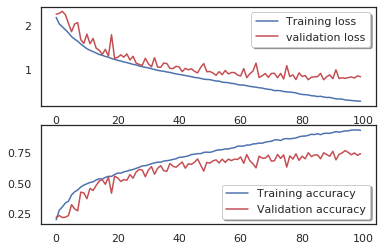

In [0]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

モデルの保存

In [0]:
###-- モデル全体を１つのHDF5ファイルに保存します。
datapath_model = "drive/My Drive/jupyter/ProbSpace/ukiyoe/save_model/"
model.save(datapath_model+'model1.h5')

# ###-- Load model file
# model = tf.keras.models.load_model('model1.h5')
# model.summary()

検証データで精度チェック

テストデータで予測

In [0]:
###---  提出用データの読み込み  ---###

###--データの読み込み
def load(f):
    return np.load(f)['arr_0']
X_submit = load(datapath+"ukiyoe-test-imgs.npz")

###--型をint --> float変換する。
X_submit = X_submit.astype(np.float32)
###-- convert from [0:255] => [0.0:1.0]
X_submit = np.multiply(X_submit, 1.0 / 255.0)

print(X_submit.shape)

(397, 224, 224, 3)


In [0]:
###---  Prediction  ---###
predicts = np.argmax(model.predict(X_submit), axis=1)
predicts.shape

(397,)

In [0]:
###---  提出ファイル作成  ---###
import pandas as pd

submit = pd.DataFrame(data={"id": [], "y": []})
submit.id = list(range(1, predicts.shape[0]+1))
submit.y = predicts
submit.to_csv("submit.csv", index=False)

print(submit.head())

from google.colab import files
files.download("submit.csv")

   id  y
0   1  4
1   2  1
2   3  3
3   4  1
4   5  1


In [0]:
###--- テストデータでテスト ---#
##-- N = 10000; Number of test images
i = 0
N = 10000
predicts = []
while i < N:
    i = i + 100
    ##--
    tem = []
    tem_1 = []
    tem_2 = []
    tem_3 = []
    tem_4 = []
    tem_5 = []
    ##--
    #tem_1 = model_1.predict(test_imgs[i-100:i])
    tem_2 = model_2.predict(test_imgs[i-100:i])
    tem_3 = model_3.predict(test_imgs[i-100:i])
    tem_4 = model_4.predict(test_imgs[i-100:i])
    tem_5 = model_5.predict(test_imgs[i-100:i])
    #tem = tem_1 + tem_2 + tem_3 + tem_4 + tem_5
    tem = tem_2 + tem_3 + tem_4 + tem_5
    ##--
    predicts = np.append( predicts, np.argmax( tem , axis=1) )
  
predicts = predicts.astype(np.int64)

predicts.shape
print(predicts)

[2 9 3 ... 9 4 2]


In [6]:
###---  提出ファイル作成  ---###
import pandas as pd
###-- 変数predictsに予測結果を入れて下さい
###-- 型はnumpy.ndarrayで
###-- shapeは(10000,)になるはずです
###-- predicts = 
submit = pd.DataFrame(data={"ImageId": [], "Label": []})

submit.ImageId = list(range(1, predicts.shape[0]+1))
submit.Label = predicts

submit.to_csv(root.joinpath("submit.csv"), index=False)